In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy import special

In [3]:
# Test filename:
#  '20190301.as-rel2.txt'

# AS graph processing

### Obtain links

In [4]:
# This code expands previous work by yymartin

Relation types to IDs conversion (adopted to numerically manipulate numpy arrays):
    - peer-peer:         0
    - provider-customer:-1
    - customer-provider: 1
    

In [5]:
def extract_links(filename):
    raw_data = pd.read_csv(filename, delimiter='\n', comment='#', header=None, encoding='ISO-8859-1')
    raw_data['provider_peer'], raw_data['customer_peer'], raw_data['relation_type'], raw_data['source'] = raw_data[0].str.split('|').str
    raw_data['relation_type']  = raw_data['relation_type'].apply(lambda x: int(x))
    links = raw_data[['provider_peer','customer_peer','relation_type']]
    return links

In [6]:
def get_nodes_edges(links):
    nodes = np.unique(links['provider_peer'].values.astype(int))
    nodes = np.unique(np.concatenate([nodes, np.unique(links['customer_peer'].values.astype(int))]))
    # Convert AS labels to int
    a_to_b_edges = links.values.astype(int)
    # Invert the edges' endpoints
    b_to_a_edges = a_to_b_edges[:, [1,0,2]]
    # Update the relations
    b_to_a_edges[:,2] = (-1) * b_to_a_edges[:,2]
    # Generate the undirected graph
    edges = np.concatenate((a_to_b_edges, b_to_a_edges), axis=0)
    return (nodes, edges[np.argsort(edges[:,0])])

In [7]:
def node_degree_distribution(nodes, edges):
    _, nd_deg = np.unique(edges[:,0], return_counts=True)
    deg_val, deg_freq = np.unique(np.array(nd_deg), return_counts=True)
    nodes_num = float(len(nodes))
    norm_freq = deg_freq / nodes_num
    return np.concatenate((np.array(deg_val)[..., np.newaxis], np.array(norm_freq)[..., np.newaxis], np.array(deg_freq)[..., np.newaxis]), axis=1)

The degree distribution has the form: \
$$    [[value_0, density_0, samples_0], \\
     [value_1, density_1, samples_1], \\
     ... \\
     [value_N, density_N, samples_N]] $$

## Load and display CAIDA data

**Disclaimer**
There is a remarkable difference in the number of links discovered in 2015 vs in 2020 (~ 20%) 

In [8]:
def load_graph(filename):
    lnks = extract_links(filename)
    (nd, ed) = get_nodes_edges(lnks)
    deg_distr = node_degree_distribution(nd, ed)
    return {'nodes': nd, 'edges': ed, 'deg_distr': deg_distr}

In [9]:
def display_graph(graph, year_label, plt_handle):
    plt_handle.scatter(graph['deg_distr'][:,0], graph['deg_distr'][:,1], label=str(year_label))

In [10]:
as_graphs = dict()
as_graphs.update(
    {2015: load_graph('20151201.as-rel2.txt'),
     2019: load_graph('20190301.as-rel2.txt'),
     2020: load_graph('20200201.as-rel2.txt')})

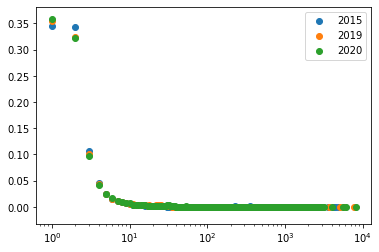

In [11]:
distr_fig = plt.figure()
distr_plt = distr_fig.add_subplot()

# Display data for 2015, 2019, 2020
for year, as_year_graph in as_graphs.items():
    display_graph(as_year_graph, year, distr_plt)

distr_plt.legend()
distr_plt.set_xscale('log')
#distr_plt.set_yscale('log')

In [12]:
print("AS 100 is connected to: \n", as_graphs[2020]['edges'][np.where(as_graphs[2020]['edges'][:,0] == 100)[0]])
print()
print("AS 201770 is connected to: \n", as_graphs[2020]['edges'][np.where(as_graphs[2020]['edges'][:,0] == 201770)[0]])

AS 100 is connected to: 
 [[   100 201770      1]
 [   100  38442      1]
 [   100 395727      1]
 [   100  29716      1]
 [   100  62812      1]
 [   100    555      1]
 [   100  46197      1]
 [   100  53652      1]]

AS 201770 is connected to: 
 [[201770    174      1]
 [201770    100     -1]]


## Classify ASes

In [13]:
study_year = 2020

In [14]:
real_nd = np.unique(as_graphs[study_year]['edges'][:,0])

In [15]:
real_nd.shape, len(set(real_nd))

((67614,), 67614)

In [16]:
with_provider_idxs = np.nonzero(as_graphs[study_year]['edges'][:,2].astype(int) == 1)
with_provider_as = np.unique(as_graphs[study_year]['edges'][with_provider_idxs, 0])
print("%f%% of ASes do not have customer-provider links (%d out of %d)" % ((1-with_provider_as.shape[0] / float(as_graphs[study_year]['nodes'].shape[0]))*100, as_graphs[study_year]['nodes'].shape[0] - 
                                                                           with_provider_as.shape[0], as_graphs[study_year]['nodes'].shape[0]))

0.627089% of ASes do not have customer-provider links (424 out of 67614)


#### Average edge degree of top-level ASes

The average degree of nodes is

In [17]:
avg_degree = 0

for asn in as_graphs[study_year]['nodes']:
    avg_degree += (as_graphs[study_year]['edges'][:,0].astype(int) == asn).sum()

avg_degree = avg_degree / float(len(as_graphs[study_year]['nodes']))
avg_degree

13.240275682550951

Whereas the average degree for ASes without provider is

In [18]:
top_level_as = set(as_graphs[study_year]['nodes']).difference(set(with_provider_as))

top_level_degrees = []

num_edges = 0
for asn in top_level_as:
    t_node_deg = (as_graphs[study_year]['edges'][:,0] == asn).sum()
    top_level_degrees.append(t_node_deg)
    num_edges += t_node_deg
    
avg_edges_t = num_edges / float(len(top_level_as))
avg_edges_t

86.85849056603773

**Observation**: 
ASes without providers in 2020 are **less connected** (i.e. they have fewer adjacent edges) than those in 2015 (-21%)

In [19]:
# Util function: Extract subgraph (as list of edges grouped by origin)
# Edges must be sorted by origin!!
def extract_subgraph(sorted_edges, sel_nodes):
    # Filter on origin
    filter_origin = sorted_edges[np.in1d(sorted_edges[:,0], sel_nodes), :]
    
    # Split based on origin
    split_on_origin = np.split(filter_origin, np.unique(filter_origin[:,0], return_index=True)[1])[1:]
    
    # Filter destinations
    filtered_graph = []
    
    for orig in split_on_origin:
        temp_orig = orig[np.in1d(orig[:,1], sel_nodes),:]
        if len(temp_orig) != 0:
            filtered_graph.append(temp_orig)
            
    return filtered_graph

### Top tier cliques?

The following graph presents only the relations among the ASes without *customer-provider* links

In [20]:
as_sorted_by_origin = as_graphs[study_year]['edges'][np.argsort(as_graphs[study_year]['edges'][:,0]),:]

top_as_array = np.array(list(top_level_as))

filtered_big_as = extract_subgraph(as_sorted_by_origin, top_as_array)

top_node_deg = np.array([[x[0,0], float(x.shape[0])] for x in filtered_big_as], dtype=object)
filtered_big_as = np.concatenate(filtered_big_as)

In [21]:
top_node_deg[:,1] = top_node_deg[:,1].astype(float) / float(np.max(top_node_deg[:,1])) * 80
top_node_deg[:,0] = top_node_deg[:,0].astype(int)

In [22]:
# Set factor for nodes not belonging to the main connected component
null_deg_list = np.array([[x, 1.] for x in np.setdiff1d(top_as_array, top_node_deg[:,0])], dtype=object)

In [24]:
# Complete array with sizes
node_size_array = np.concatenate([top_node_deg, null_deg_list])
node_size_array = node_size_array[np.argsort(node_size_array[:,0]), :]

In [25]:
# Biggest 64 ASes from CAIDA's ASRank
empirical_top = np.array([3356,1299,174,3257,2914,6762,6939,6453,3491,6461,1273,3549,9002,5511,4637,12956,7473,209,12389,3320,701,7018,7922,20485,3216,16735,9498,31133,6830,20764,2828,52320,15412,1239,8359,286,43531,58453,10429,262589,28917,37468,4809,4755,7738,33891,31500,41095,4766,8220,4826,11537,7843,18881,29076,34800,46887,4230,5483,20804,4134,8167,267613,7029])

In [26]:
msk = empirical_top[np.in1d(empirical_top, np.unique(filtered_big_as[:,0]))]
msk, msk.shape[0]/float(64)

(array([ 3356,  1299,   174,  3257,  2914,  6762,  6453,  3491,  6461,
         5511, 12956,   209,  3320,   701,  7018,  6830,  2828,  1239,
          286]), 0.296875)

`filtered_big_as` contains the 29.68% of the biggest ASes (from CAIDA's ASRank)

In [27]:
len(top_level_as), len(np.unique(filtered_big_as[:,0]))

(424, 64)

In [28]:
top_as_graph = nx.Graph()
top_as_graph.add_nodes_from(top_node_deg[:,0])
for o, d in filtered_big_as[:, [0,1]]:
    top_as_graph.add_edge(o, d)

C:\Users\Matteo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


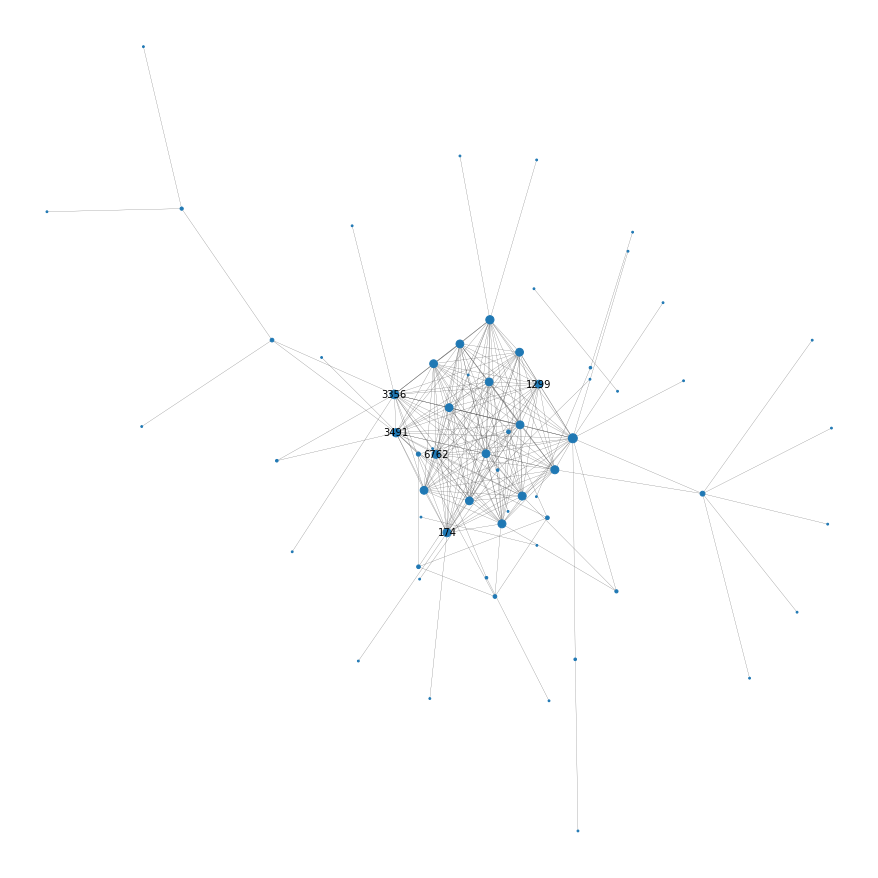

In [29]:
plt.figure(3,figsize=(12,12)) 
nx.draw_kamada_kawai(top_as_graph, 
                     node_size=top_node_deg[:,1].tolist(), 
                     style='-', width=.2, 
                     node_shape='o', 
                     size=100, 
                     labels={3356:"3356",  1299:"1299",   174:"174",  6762:"6762",  3491:"3491"},
                     font_size=10,
                     font_weight='light',
                     edge_color='#444444'
                    )
plt.savefig("figs/top_ases.svg")

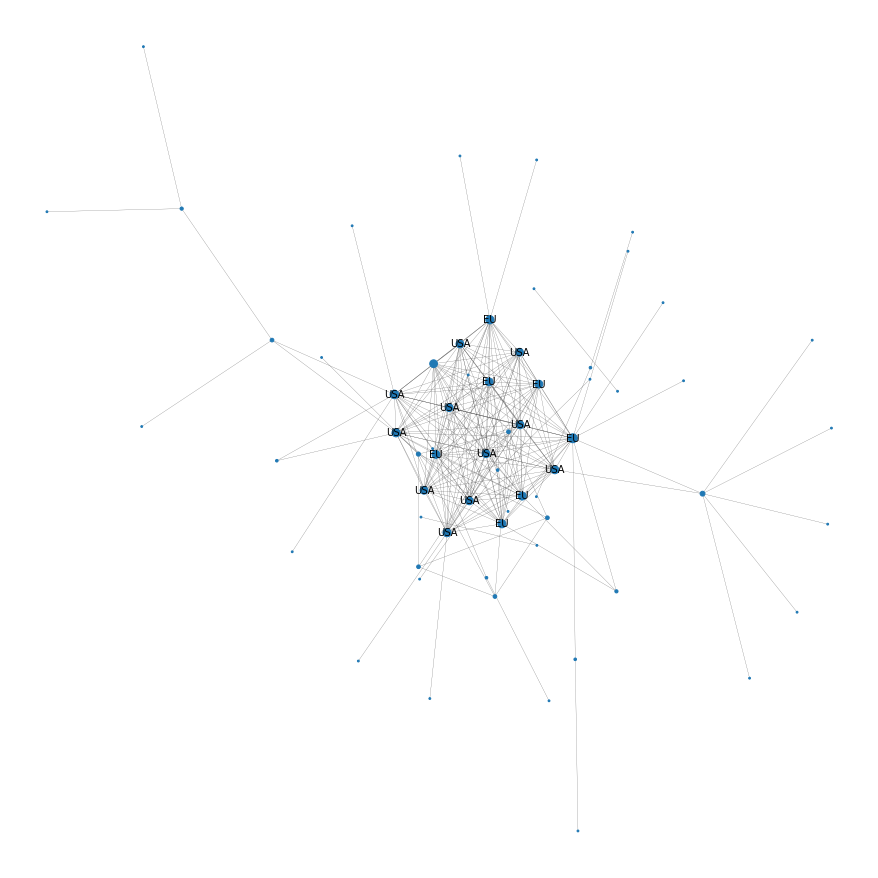

In [33]:
plt.figure(3,figsize=(12,12)) 
nx.draw_kamada_kawai(top_as_graph, 
                     node_size=top_node_deg[:,1].tolist(), 
                     style='-', width=.2, 
                     node_shape='o', 
                     size=100, 
                     labels={3356:"USA",
                             1299:"EU",
                             174:"USA",
                             6762:"EU",
                             3491:"USA",
                             3257: "EU",
                             2914: "USA",
                             6453: "USA",
                             3491: "USA",
                             6461: "USA",
                             5511: "EU",
                             12956: "EU",
                             209: "USA",
                             3320: "EU",
                             701: "USA",
                             7018: "USA",
                             6830: "EU",
                             2828: "USA",
                             1239: "USA"
                            },
                     font_size=10,
                     font_weight='light',
                     edge_color='#444444'
                    )

### Bigger provider ASes

It could be reasonable to think that the number of links could be a good metric to evaluate the size of ASes (as in ASRank) but it turns out that, among the 64 biggest ASes (ordered by degree), only 28% coincide with the biggest 64 from CAIDA.

I hence turn to the **number of provider-to-customer links**

In [34]:
as_split_list = np.split(as_sorted_by_origin, np.unique(as_sorted_by_origin[:,0], return_index=True)[1])[1:]

def ratio_estimator(x):
    p2c_links = (x[:,2] == -1).sum()
    return p2c_links

as_links_num = np.array([[x[0,0], ratio_estimator(x)] for x in as_split_list], dtype=int)

# Reverse sort by number of links
as_links_num = as_links_num[np.argsort(as_links_num[:,1])[::-1],:]
as_links_num

array([[   174,   5995],
       [  3356,   5359],
       [  7018,   2465],
       ...,
       [134131,      0],
       [134130,      0],
       [ 52536,      0]])

In [35]:
as_links_num[:,1] = 1 + as_links_num[:,1]

In [36]:
np.average(as_links_num[:,1])

2.9817197621794302

In [38]:
as_links_num[:64, 0]

array([   174,   3356,   7018,   3549,   1299,   3257,    209,   6461,
         2914,   6939,    701,  12389,   9498,   8220,   9002,  46887,
         4826,   3216,  13101,   6830,   2828,   4755,  20485,   6453,
        16735,   3320,   3491,  22773,  31133,   4766,   6762,  10429,
        12741,   5588,   8359,   7029,   4637,  20115,   1221,   3786,
        32787,   8708,  20473,   7717,   9318,   1239,  54004, 201054,
         4230,   7474,  50607,  20764,   3326, 201053,  55410,   9049,
        10796,   5617,   4809,   7713,   8218,    577,  33491,  12874])

## SAVE ASes by number of customers

In [603]:
np.savetxt("simulation/data/" + str(study_year) + "-as-hierarchy.csv", as_links_num, fmt=['%d', '%d'], delimiter=',')

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [378]:
# Take the 64 most connected ASes
most_connected_64 = as_links_num[:64,0]

In [497]:
connected_as_list = extract_subgraph(as_sorted_by_origin, most_connected_64)
most_connected_subgraph = np.concatenate(connected_as_list)

In [498]:
absent_in_subgraph = np.array([[x, 1] for x in np.setdiff1d(most_connected_64, np.unique(most_connected_subgraph[:,0]))])
absent_in_subgraph

array([[54004,     1]])

In [499]:
connected_sizes = [[x[0,0], x.shape[0]] for x in connected_as_list]
for a in absent_in_subgraph:
    connected_sizes.append(a)
connected_sizes = np.array(connected_sizes)

In [500]:
connected_sizes = connected_sizes[np.argsort(connected_sizes[:,0]),:]
connected_sizes[:,1] = connected_sizes[:,1] / float(np.max(connected_sizes[:,1])) * 80

In [501]:
most_connected_nx = nx.Graph()
most_connected_nx.add_nodes_from(np.sort(most_connected_64))
for o, d in most_connected_subgraph[:, [0,1]]:
    most_connected_nx.add_edge(o, d)

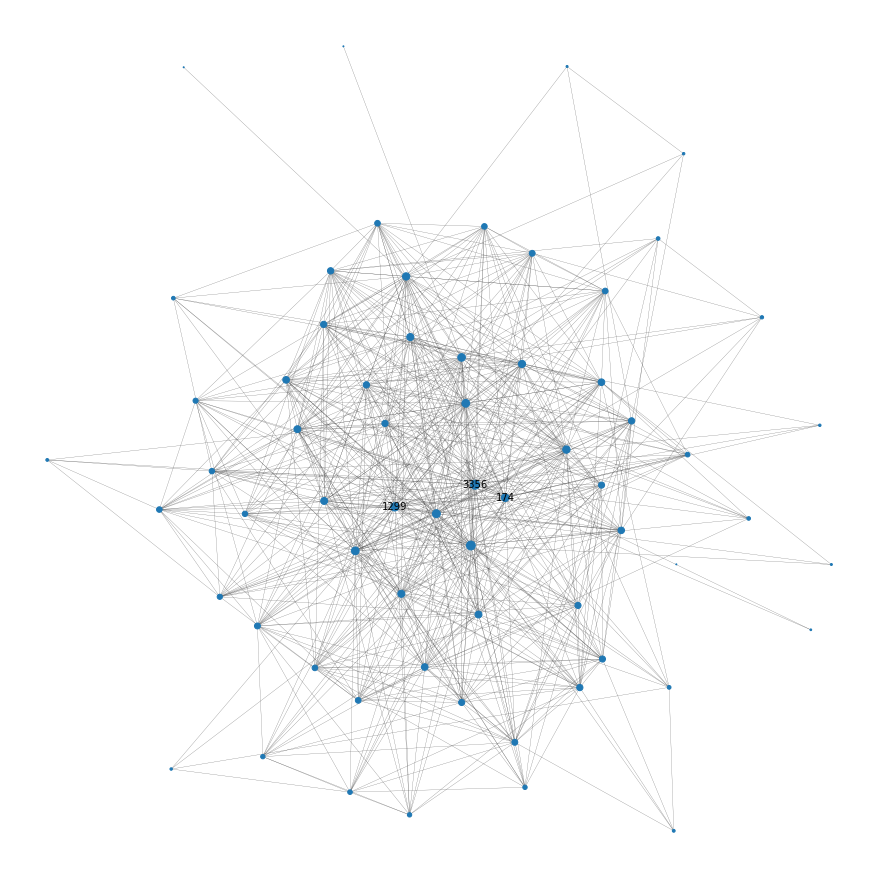

In [502]:
plt.figure(3,figsize=(12,12)) 
nx.draw_kamada_kawai(most_connected_nx, 
                     style='-', width=.2, 
                     node_shape='o', 
                     node_size=connected_sizes[:,1], 
                     labels={3356:"3356",  1299:"1299",   174:"174"},
                     font_size=10,
                     font_weight='light',
                     edge_color='#444444'
                    )
plt.savefig("figs/most_customers.svg")

In [503]:
# Compare to ASRank
conn = most_connected_64
conn, np.in1d(empirical_top, most_connected_64).sum() / float(64)

(array([   174,   3356,   7018,   3549,   1299,   3257,    209,   6461,
          2914,   6939,    701,  12389,   9498,   8220,   9002,  46887,
          4826,   3216,  13101,   6830,   2828,   4755,  20485,   6453,
         16735,   3320,   3491,  22773,  31133,   4766,   6762,  10429,
         12741,   5588,   8359,   7029,   4637,  20115,   1221,   3786,
         32787,   8708,  20473,   7717,   9318,   1239,  54004, 201054,
          4230,   7474,  50607,  20764,   3326, 201053,  55410,   9049,
         10796,   5617,   4809,   7713,   8218,    577,  33491,  12874]),
 0.578125)

That metric reflects remarkably better ASRank: **57.8% agreement** (among the 64 bigger)

### Peering relations

In [20]:
only_peers_idxs = np.nonzero(as_graphs[study_year]['edges'][:,2].astype(int) == 1)

## Study graph structure

In [21]:
graph = nx.Graph()
graph.add_nodes_from(as_graphs[study_year]['nodes'])
for ne1, ne2 in as_graphs[study_year]['edges'][:10, [0,1]]:
    graph.add_edge(ne1, ne2)

In [22]:
nx.degree_assortativity_coefficient(graph)

-1.0

In [23]:
def shortest_path(s,t,G):
    actual_paths = []
    paths = nx.all_shortest_paths(G,s,t)
    for path in paths:
        actual_path = []
        for i in range(len(path)-1):
            l = tuple([path[i],path[i+1]])
            actual_path.append(links_rel[l])
        actual_paths.append(actual_path)
    return actual_paths

# Build mixed distribution

This analysis follows the proposals by Clauset et al. [??Ref]

In [27]:
from scipy.special import zeta
from scipy.special import gamma
from scipy.special import beta

In [28]:
def mixed_powerlaw(a_param, x_min_param, init_pdf):
    assert init_pdf.shape[0] == x_min_param, "Wrong size of initial pdf"
    
    init_prob_mass = init_pdf.sum()
    assert init_prob_mass < 1
    
    norm_fact = (1/zeta(a_param, x_min_param)) * (1 - init_prob_mass)
    def pdf(x_param):
        x_param = np.copy(x_param)
        not_from_powerlaw = np.nonzero(x_param < x_min_param)[0]
        not_powerlaw_indexes = x_param[not_from_powerlaw]
        
        # Avoid divison by zero
        x_param[not_from_powerlaw] = 1
        
        # Compute the pdf
        x_pdf = norm_fact * pow(x_param, -a_param)
        
        # Insert density for points under x_min_param
        x_pdf[not_from_powerlaw] = init_pdf[not_powerlaw_indexes]
        return x_pdf
    return pdf

`mixed_powerlaw()` returns the probability density function `pdf` of a r.v.:
  1. following a power law (of parameter `a`) for values bigger than `x_min`.
  2. such that `pdf(x) == init_pdf[x]` if `x < x_min`:

In [29]:
def mixed_exponential(lambda_param, x_min_param, init_pdf):
    assert init_pdf.shape[0] == x_min_param, "Wrong size of initial pdf"
    
    init_prob_mass = init_pdf.sum()
    assert init_prob_mass < 1
    
    norm_fact = (1-math.exp(-lambda_param)) * math.exp(lambda_param * x_min_param) * (1-init_prob_mass)
    def pdf(x_param):
        x_param = np.copy(x_param)
        not_from_exponential = np.nonzero(x_param < x_min_param)[0]
        not_exponential_indexes = x_param[not_from_exponential]
        
        # Compute the pdf
        x_pdf = norm_fact * np.vectorize(math.exp)(- lambda_param * x_param)
        
        x_pdf[not_from_exponential] = init_pdf[not_exponential_indexes]
        return x_pdf
    return pdf

In [30]:
def mixed_yule_simon(alpha_param, x_min_param, init_pdf):
    assert init_pdf.shape[0] == x_min_param, "Wrong size of initial pdf"

    init_prob_mass = init_pdf.sum()
    assert init_prob_mass < 1
    
    norm_fact = (alpha_param - 1) * gamma(alpha_param - 1) * (1-init_prob_mass)
    
    # Additional part to the normalizing factor (see computation note below)
    norm_fact *= 1 / (gamma(alpha_param) * beta(x_min_param, alpha_param - 1))
    
    def pdf(x_param):
        x_param = np.copy(x_param)
        from_transient = np.nonzero(x_param < x_min_param)[0]
        from_transient_values = x_param[from_transient]
        
        x_param[from_transient] = 1

        # Compute pdf
        x_pdf = norm_fact * np.vectorize(lambda in_array: beta(in_array, alpha_param))(x_param)

        x_pdf[from_transient] = init_pdf[from_transient_values]
        return x_pdf
    return pdf

**Disclaimer:**
To compute the mixed Yule-Simon distribution (of parameter $\alpha$ and asymptotic behavior starting at $x_{min}$) above, the following equality is exploited:
$$ \frac{\Gamma(a)}{\Gamma(a+b)} = \frac{B(a,b)}{\Gamma(b)} $$

This is useful since the pdf can be rewritten as
$$ p(x) = \frac{\Gamma(x)}{\Gamma(x + \alpha)} \cdot (\alpha-1) \frac{\Gamma(x_{min} + \alpha - 1)}{\Gamma(x_{min})} = B(x, \alpha) \cdot \frac{(\alpha - 1) \Gamma(\alpha - 1)}{\Gamma(\alpha)B(x_{min}, \alpha - 1)} $$

where the $\Gamma$ function is only evaluated for small arguments.

#### Useful statistical tools

In [31]:
def discrete_powerlaw_mle(x_min, empirical_values):
    samples_num = empirical_values.shape[0]
    return 1 + samples_num * math.pow(np.vectorize(math.log)(empirical_values/(x_min-.5)).sum(), -1)

For a given `x_min`, `discrete_powerlaw_mle()` computes an estimator for `a` from empirical samples using the approximation (from Clauset):
$$\hat\alpha \simeq 1 + \frac{n}{\bigg( \sum\limits_{i = 0}^{n-1} \log{\frac{x_i}{x_{min} - \frac{1}{2}}} \bigg)}$$

In [32]:
def build_approx_powerlaw(x_min_param, graph):
    alpha_hat = discrete_powerlaw_mle(x_min_param, graph['edges'][:,0])
    initial_distr = np.concatenate([np.array([[0,0]]), graph['deg_distr'][:x_min_param-1, 0:2]], axis=0)
    return mixed_powerlaw(alpha_hat, x_min_param, initial_distr[:,1])

In [33]:
def kolmogorov_smirnov_test(degree_distribution, powerlaw_pdf, significance_level):
    max_deg = int(degree_distribution[:,0].max())
    cdf_support = range(0, max_deg+1)
    theoretical_cdf = np.matmul(np.tril(np.ones([max_deg+1, max_deg+1]), 0), powerlaw_pdf(np.array(cdf_support)))
    
    # Unroll empirical pdf
    unrolled_empirical_pdf = np.zeros(max_deg+1)
    unrolled_empirical_pdf[degree_distribution[:, 0].astype(int)] = degree_distribution[:,1] # Assign density 0 to asbent degrees
    
    empirical_cdf = np.matmul(np.tril(np.ones([max_deg+1, max_deg+1]), 0), unrolled_empirical_pdf)
    
    # Compute max distance between cdf
    distance_vector = np.absolute(empirical_cdf - theoretical_cdf)
    d_val = distance_vector.max()
    
    ks_fig = plt.figure()
    ks_plt = ks_fig.add_subplot()

    ks_plt.plot(cdf_support, theoretical_cdf, label='theory')
    ks_plt.plot(cdf_support, empirical_cdf, label='empirical')
    ks_plt.plot(cdf_support, distance_vector, label='distance magnitude')
    ks_plt.set_xscale('log')
    ks_plt.legend()
    
    # Determine outcome of the test
    threshold = math.sqrt(- math.log(significance_level/2)) / math.sqrt(max_deg+1)
    
    return {'sup_distance': d_val, 'threshold': threshold, 'null_rejected': d_val > threshold}

`kolmogorov_smirnov_test()` performs the Kolmogorov-Smirnov test over $n$ samples, at significance $\alpha$, and returns a dictionary containing:
  1. `sup_distance`: the largest (absolute value of the) distance between the empirical and theoretical Cumulative Distribution Function
  2. `threshold`: the threshold above which the null hypothesis is rejected, calculated as
  $$ \tau = \frac{1}{\sqrt{n}} \cdot \sqrt{-\log{\frac{\alpha}{2}}} $$
  3. `null_rejected`: boolean, true if `sup_distance` $ > \tau$

In [34]:
stats.ks_2samp(stats.expon.rvs(size=10), stats.expon.rvs(size=10))

Ks_2sampResult(statistic=0.4, pvalue=0.41752365281777043)

## Compare approximation performances

In [35]:
print(discrete_powerlaw_mle(2, as_graphs[study_year]['edges'][:,0]), 
      discrete_powerlaw_mle(1, as_graphs[study_year]['edges'][:,0]), 
      discrete_powerlaw_mle(4, as_graphs[study_year]['edges'][:,0]),
      discrete_powerlaw_mle(6, as_graphs[study_year]['edges'][:,0]))

1.100788987015484 1.0907413743311547 1.110199867602984 1.115976506725736


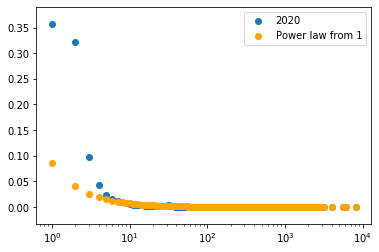

In [292]:
distr_fig = plt.figure()
comp_plt = distr_fig.add_subplot()

display_graph(as_graphs[study_year], str(study_year), comp_plt)

comp_supp = as_graphs[study_year]['deg_distr'][:,0].astype(int)
estimated_distr_1 = build_approx_powerlaw(1, as_graphs[study_year])
comp_plt.scatter(comp_supp, estimated_distr_1(comp_supp), label='Power law from 1', color='orange')
estimated_distr_4 = build_approx_powerlaw(4, as_graphs[study_year])
#comp_plt.scatter(comp_supp, estimated_distr_4(comp_supp), label='Power law from 4', color='yellowgreen')
estimated_distr_6 = build_approx_powerlaw(6, as_graphs[study_year])
#comp_plt.scatter(comp_supp, estimated_distr_6(comp_supp), label='Power law from 6', color='red')

comp_plt.legend()
comp_plt.set_xscale('log')

{'sup_distance': 0.09325812215423057,
 'threshold': 0.016802319389166844,
 'null_rejected': True}

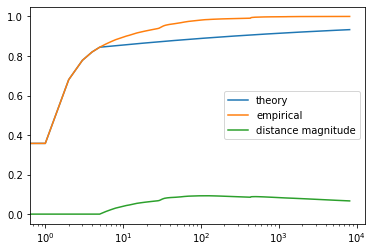

In [37]:
kolmogorov_smirnov_test(as_graphs[study_year]['deg_distr'], estimated_distr_6, .2)

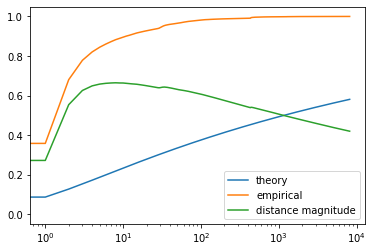

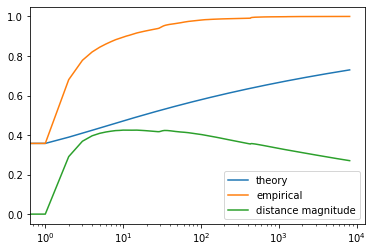

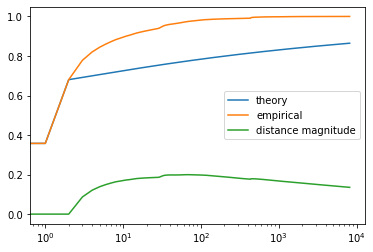

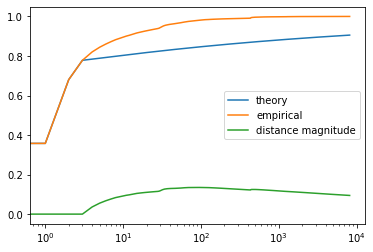

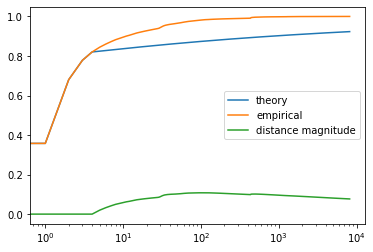

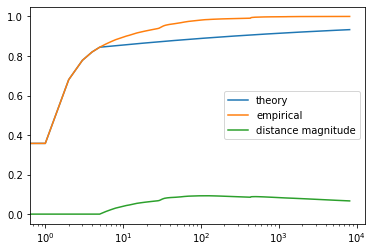

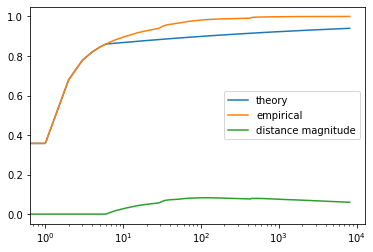

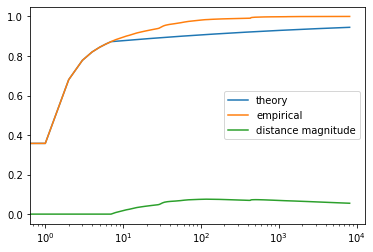

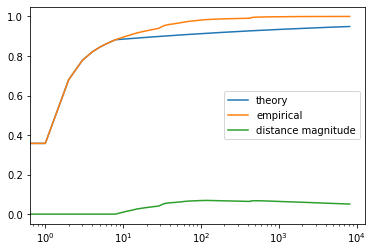

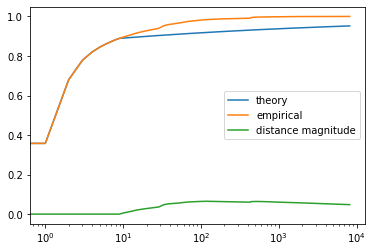

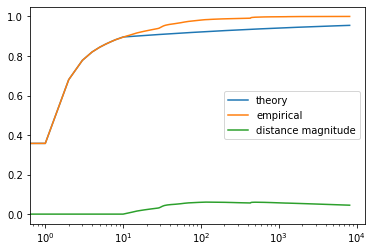

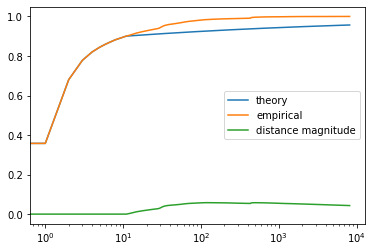

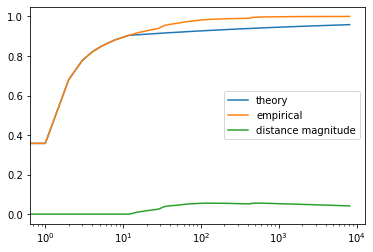

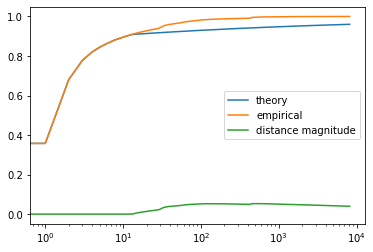

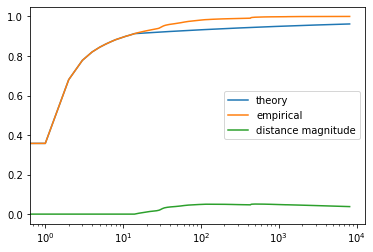

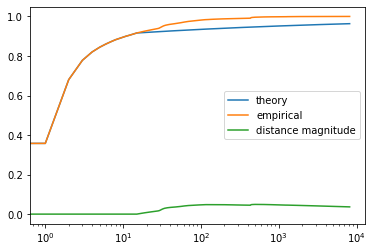

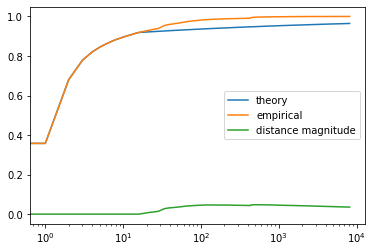

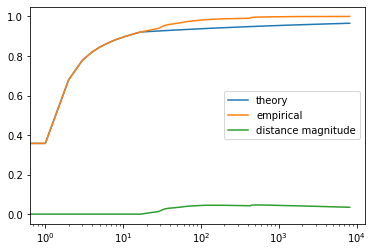

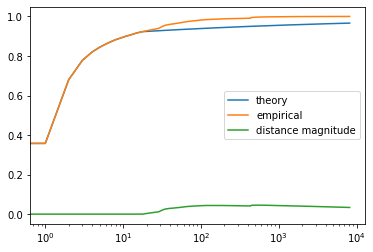

In [38]:
[kolmogorov_smirnov_test(as_graphs[study_year]['deg_distr'], build_approx_powerlaw(xm, as_graphs[study_year]), .2)['null_rejected'] for xm in range(1, 20)];

### Trying with exponential approximation...

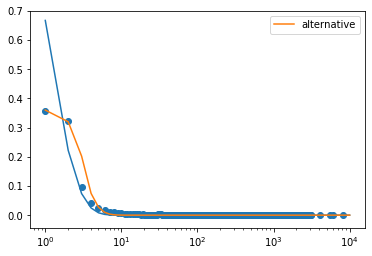

In [41]:
expon_fig = plt.figure()
expon_plt = expon_fig.add_subplot()

expon_plt.plot(range(1, 10000), mixed_exponential(1.1, 1, np.array([0]))(np.array(range(1, 10000))))
expon_plt.plot(range(1, 10000), mixed_exponential(1.0000000000000001, 3, np.array([0, .36, .32]))(np.array(range(1, 10000))), label='alternative')
expon_plt.scatter(as_graphs[study_year]['deg_distr'][:, 0], as_graphs[study_year]['deg_distr'][:,1])
expon_plt.set_xscale('log')
expon_plt.legend()

{'sup_distance': 0.08541451857164961,
 'threshold': 0.02126711714056623,
 'null_rejected': True}

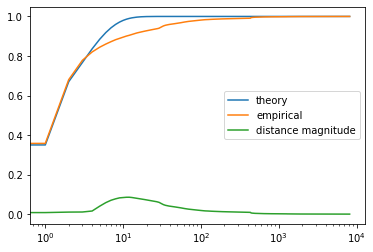

In [47]:
kolmogorov_smirnov_test(as_graphs[study_year]['deg_distr'], mixed_exponential(.35, 3, np.array([0, .35, .32])), .05)

In [46]:
as_graphs[study_year]['deg_distr']

array([[1.00000000e+00, 3.57780933e-01, 2.41910000e+04],
       [2.00000000e+00, 3.22448014e-01, 2.18020000e+04],
       [3.00000000e+00, 9.79087171e-02, 6.62000000e+03],
       ...,
       [5.55800000e+03, 1.47898364e-05, 1.00000000e+00],
       [6.09000000e+03, 1.47898364e-05, 1.00000000e+00],
       [8.15500000e+03, 1.47898364e-05, 1.00000000e+00]])

### And now with Yule-Simon

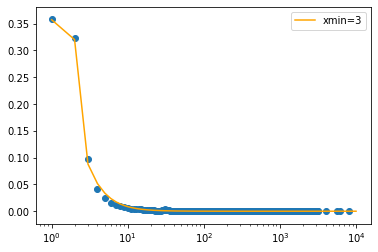

In [48]:
yulesim_fig = plt.figure()
yulesim_plt = yulesim_fig.add_subplot()

yulesim_plt.plot(range(1, 10000), mixed_yule_simon(2.120, 3, np.array([0, .357, .32]))(np.array(range(1, 10000))), label='xmin=3', color='orange')
yulesim_plt.scatter(as_graphs[study_year]['deg_distr'][:, 0], as_graphs[study_year]['deg_distr'][:,1])

yulesim_plt.set_xscale('log')
yulesim_plt.legend()

{'sup_distance': 0.02973657607579072,
 'threshold': 0.02126711714056623,
 'null_rejected': True}

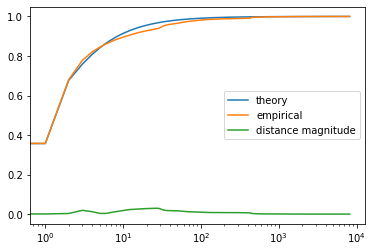

In [49]:
kolmogorov_smirnov_test(as_graphs[study_year]['deg_distr'], mixed_yule_simon(2.021, 3, np.array([0, .357, .32])), .05)

In [50]:
# Experimental
# TODO: not yet working
def yule_simon_alpha_estimation_fp(deg_distr, x_min_param):
    asymptotic_distr = deg_distr[np.nonzero(deg_distr[:,0] >= x_min_param), ...]
    asymptotic_distr = asymptotic_distr[:,[0,2]]
    N = deg_distr[:,1].sum()
    converged = False
    alpha_hat = 2.
    while not converged:
        denom = 0.
        for deg_val, deg_num_samples in deg_distr[:,0:2]:
            round_sum = 0.
            for i in range(1, int(deg_val)+1):
                round_sum += 1 / float(alpha_hat + i)
            denom += round_sum * deg_num_samples
        new_alpha = N / denom
        
        if (abs(new_alpha - alpha_hat) < .000001):
            converged = True
        alpha_hat = new_alpha
        print(alpha_hat)
        
    return alpha_hat

In [51]:
yule_simon_alpha_estimation_fp(as_graphs[study_year]['deg_distr'], 3)

1.2144140635834517
0.9882316179943853
0.9183078634582342
0.8961477236592648
0.8890669594316261
0.8867984501108254
0.8860710524025435
0.8858377482915736
0.8857629122044179
0.8857389066349171
0.8857312061710371
0.8857287360227585
0.8857279436499493


0.8857279436499493

## 2015 data

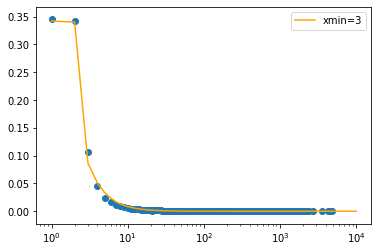

In [55]:
yulesim_fig = plt.figure()
yulesim_plt = yulesim_fig.add_subplot()

yulesim_plt.plot(range(1, 10000), mixed_yule_simon(2.121, 3, np.array([0, .342, .34]))(np.array(range(1, 10000))), label='xmin=3', color='orange')
yulesim_plt.scatter(as_graphs[2015]['deg_distr'][:, 0], as_graphs[2015]['deg_distr'][:,1])

yulesim_plt.set_xscale('log')
yulesim_plt.legend()

{'sup_distance': 0.03689161196563118,
 'threshold': 0.02746583471343839,
 'null_rejected': True}

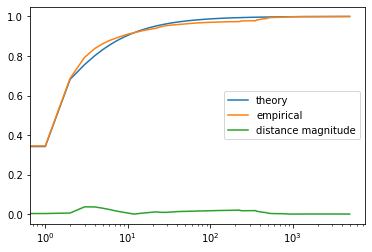

In [56]:
kolmogorov_smirnov_test(as_graphs[2015]['deg_distr'], mixed_yule_simon(1.92, 3, np.array([0, 0.342, 0.34])), .05)